(azdepth_ppc)=
# ArviZ in depth: plot_ppc

:::{post} November 17, 2023
:category: python, arviz
:tags: visualization, posterior predictive, model criticism
:exclude:

All the tips (and tricks) you never knew you needed to use plot_ppc
:::

:::{image} ppc_rugby_home_effect.png
:alt:
:class: hidden-metadata
:::

## Overview

I might write a post some day on posterior predictive in general, but today is not that day. Today we will dive into `plot_ppc` function of ArviZ and everything you can do with it.
There are many possibilities in the {func}`arviz.plot_ppc` use alone, but there are infinite more in the world of posterior predictive checking in general. The same applies to prior predictive checking too.

The basic idea of posterior predictive checking is that whenever we have fitted a generative model, we can simulate observations _according to our model_. Thus, if our model is believable, these simulated observations should be similar to our actual observations. We don't call them "simulated observations" though, what we are doing is technically using our model to predict at the same places we had observations. If our posterior distribution is the description of the joint probability in our _paremeter space_, the posterior predictive one is its equivalent in our _observation space_.

This same idea applies to prior sampling. We can also check the prior predictive distribution and see if _at that stage_ these simulated observations are believable. If our observations can only be positive and the prior predictive assigns a lot of probability to negative values we might want to constrain our priors better to fit our knowledge. If our observations can be both positive and negative but the prior predictive only simulates positive observations, then we already know, before seeing any actual data, that this model won't work.

`plot_ppc` helps with checking the marginals of the prior or posterior predictive distribution. It has multiple views available, and how we marginalize can be customized, but it is only for checking 1D marginal distributions.

The interpretation at the good/bad level is the same independently of the view we use: **if we are unable to distinguish which is the line/drawing that corresponds to the observations unless we look at its different properties, then the model is generating believable observations**. However, diagnosing why the model is not fitting the observations or what could be improved with it depends on the view.

### How `plot_ppc` works under the hood
Once we have a fitted model, we can generate posterior predictive samples with an extra forward sampling step. It will then generate a visualization with our observed data, and loop over the generated posterior predictive samples (or more commonly a subset of those samples). For each of these posterior predictive samples (we'll generally have as many as posterior samples) it will generate the same visualization and overlay it on the initial plot with the observed data. Eventually, it can also take all the samples at once and plot this extra aggregate line.

As it can be seen in the data below, each sample (unique combination of chain+draw) in the `posterior_predictive` group, has the same shape as the observed data, which is why we can directly compare each of our posterior predictive samples to our observations. In fact, if our model were the real data generating process, and our fit had converged, our observations would actually be one realization of that data generating process. The same can't be said about the aggregate line though. This one combines information from all draws, so it has much less variability, it is similar (yet not equivalent) to comparing samples from a distribution to its mean.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

xr.set_options(display_expand_attrs=False)

radon = az.load_arviz_data("radon")
rugby = az.load_arviz_data("rugby")
schools = az.load_arviz_data("non_centered_eight")

In [2]:
radon.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, obs_id: 919)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, obs_id) float64 ...
Attributes: (4)

In [3]:
radon.observed_data

<xarray.Dataset>
Dimensions:  (obs_id: 919)
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 911 912 913 914 915 916 917 918
Data variables:
    y        (obs_id) float64 ...
Attributes: (4)

## `kind`

The `kind` argument is the one that chooses which view to use. There are three options:

* **"kde"**: Using "kde" as `kind` sets the view to the probability density/mass function. Thus, depending on the type of data, KDEs or histograms will be used.
  There is currently no way to have histograms for float variables when using `plot_ppc`.
* **"cumulative"**: Using "cumulative" sets the view to the cumulative density function.
* **"scatter"**: Using "scatter" sets the view to stacked rug plots, with each rugplot at a different y value.

::::{admonition} What is a rug plot?
:class: tip, dropdown

A rug plot is a 1D graphic. Given a set of data or samples, we represent each point as a mark along the real line. For example, if our data is `[-1, 0.1, 0.2, 0.3, 1, 2]` our rug plot
would be:

![A horizontal line representing a numerical axis with dots at -1, 0.1, 0.2, 0.3, 1 and 2.](rug_example.png)

Rug plots are often incorporated into other plots, generally in their margins, either to give the viewer a better of the _raw_ data being plotted or to complement it.
For example, in {func}`~arviz.plot_trace` a rug plot is incorporated into both columns whenever divergences are present. In the left column the rug plot represents the
samples where divergences occurred whereas in the right column, the rug plot indicates which are the draws where divergences happened.

In other cases, such as this one, rug plots are stacked as a way to compare raw data visually in a more direct and intuitive way than say columns in a table.

::::

When we have a lot of observations, the "scatter" kind is not a good choice, whereas on the other hand, when we have very few data points, the "kde" (and to a lesser extend the "cumulative") kinds are then the bad choice. Here we will use the "kde" and "cumulative" kinds to generate ppc plots for all observations, and the "scatter" one to generate ppc plots for the first and first 5 observations:

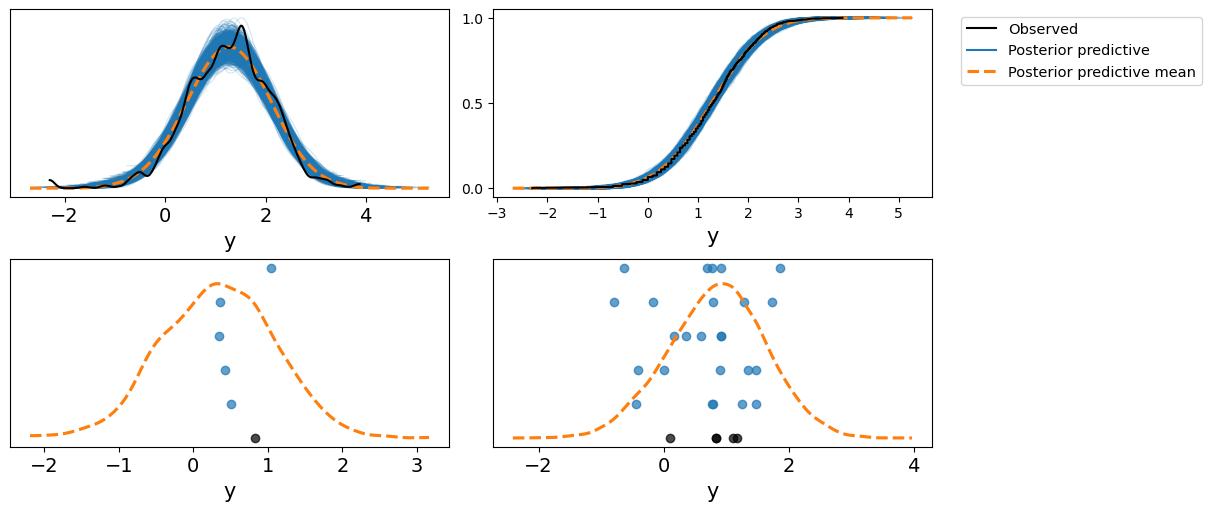

In [4]:
_, axes = plt.subplots(2, 2, figsize=(12, 5), layout="constrained")

az.plot_ppc(radon, kind="kde", ax=axes[0, 0], legend=False)
az.plot_ppc(radon, kind="cumulative", ax=axes[0, 1], legend=True)
az.plot_ppc(radon, kind="scatter", coords={"obs_id": [0]}, ax=axes[1, 0], legend=False)
az.plot_ppc(radon, kind="scatter", coords={"obs_id": [0, 1, 2, 3, 4]}, ax=axes[1, 1], legend=False)
axes[0, 1].get_legend().set(bbox_to_anchor=(1.05, 1), loc='upper left');

The figure above shows 4 different posterior predictive checks on the radon dataset. Its observations are the logarightm of radon concentration in the air, so they can take both positive and negative values. The first two panels show the checks for all data, one with a KDE the other using ECDF plots, everything else is the same:

* The black line ("Observed" in the legend) is the one that corresponds to the observations
* The blue lines ("Posterior predictive" in the legend) are the ones that correspond to a each specific posterior predictive sample
* The dashed orange ("Posterior predictive mean" in the legend) line is the one that corresponds to the aggregate line using all available posterior predictive samples.

Especially on the KDE, but also a bit in the ECDF, we see that the black line is very similar to all blue lines, it's even really close to the orange one. But there are a couple places where the black one is among the most extreme blue lines. We can try to look deeper into that in the coming sections, using other `plot_ppc` features.

The last two panels use the "scatter" kind, and show 6 rug plots stacked along the y axis, toghether with the dashed orange line. Even when we are only ploting the `obs_id=0` subset, we still have 4000 posterior predictive samples that correspond to it, so we can always generate a KDE/ECDF for this aggregate quantity.


:::{tip}
We have called `plot_ppc` multiple times, and used the `legend` argument to generate only one legend. Moreover, we have moved the legend outside the plot to prevent it from
covering any of the actual plotted data. When facetting, `plot_ppc` generates only one legend per figure, but it might still be better to move it outside the plot.
There will be an example of that in the last section of the blog post.
:::

If we use `plot_ppc` on discrete data we get histograms. And even if they are arguably uglier, everything remains largely the same.

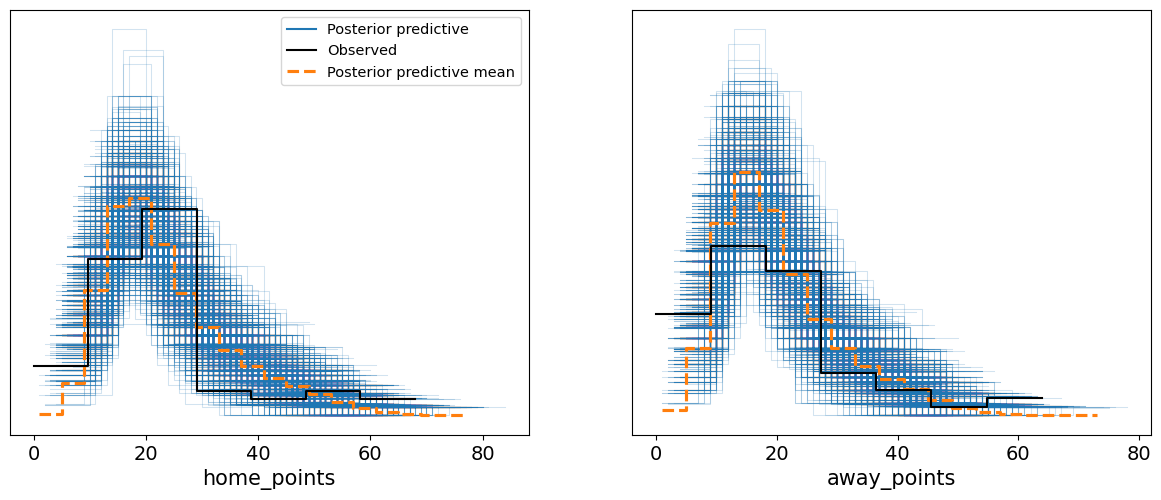

In [5]:
az.plot_ppc(rugby);

## `mean`

The next argument we'll dive into is the `mean` one, which takes a boolean. It indicates weather this "mean" line, shown above in dashed orange, should be added to the plot.

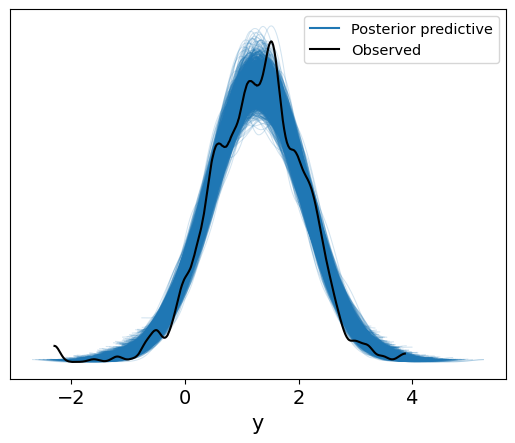

In [6]:
az.plot_ppc(radon, mean=False);

What even is this line though? This KDE//hist aggregate generated using all posterior predictive samples, mostly gives a more _global_ and less noisy view of the model predictions.
I emphasized _global_ because sometimes predictions can be quite different between draws, in which case, this aggregate will be misleading because there isn't really any global behaviour to capture.

Here is a toy example of such behaviour. I generate fake posterior predictive values and observations from a standard normal. However, the posterior predictive samples have a caveat. In the first chain, the standard normal is truncated at 0 and only the left tail is kept, whereas in the 2nd chain, we still truncate at 0 but keep the right tail only. This model is a disaster, there isn't a single prediction with both positive and negative values, and we see how the black line is very different from _all_ blue ones. When we generate the aggregate however, we do have roughly a standard normal, with only a slight lack of values around 0, so the orange dashed line has nothing to do with the blue ones and is closer to the black one even.

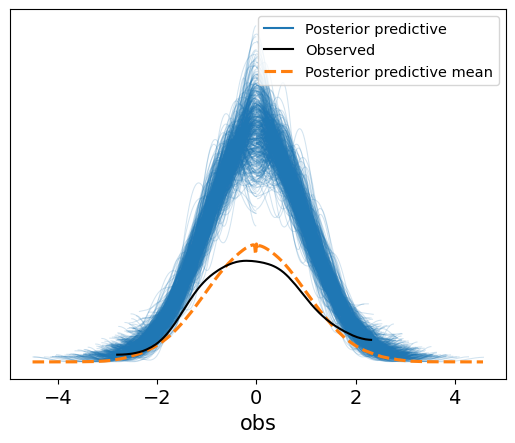

In [7]:
from scipy.stats import truncnorm, norm
import numpy as np

pp = np.stack((truncnorm.rvs(-np.infty, 0, size=(500, 157)), truncnorm.rvs(0, np.infty, size=(500, 157))))
observed = norm.rvs(size=157)
idata = az.from_dict(observed_data={"obs": observed}, posterior_predictive={"obs": pp})
az.plot_ppc(idata);

## `observed` and `observed_rug`

Next up are the `observed` and `observed_rug` arguments. `observed` is a boolean flag to indicate wheather the observations should be plotted or not, which can be handy when using `plot_ppc` for prior predictive checks as we may not have observations yet. The `observed_rug` argument adds a rug plot of the observations below the standard `plot_ppc`. Therefore it can't be used with "scatter" as it would be redundant with the rug plot already at y=0. This can be a great complement to the plot when there aren't a lot of observations, when the KDE can be hard to interpret or directly a bad choice.

Do keep in mind however that exactly the same processing happens for all posterior predictive samples and for observations, so even if he probability distribution is a bad representation or hard to read, they are still comparable.

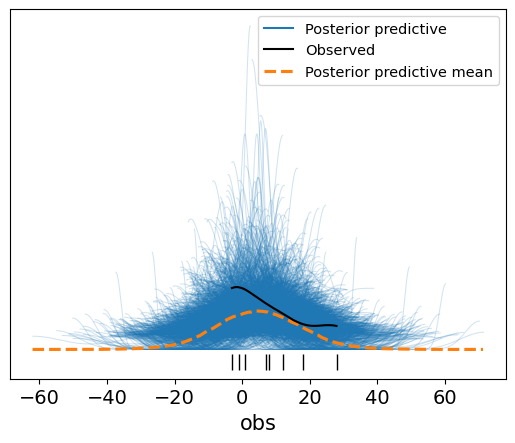

In [8]:
az.plot_ppc(schools, observed_rug=True);

## `data_pairs`

In some {abbr}`PPLs (Probabilistic Programming Languages)` variables can't repeat their names, so we need to use `data_pairs` to indicate how to compare the variables in the `observed_data` group with the ones in `posterior_predictive`. We'll rename the variable in our posterior predictive group to show an example of `data_pairs` usage:

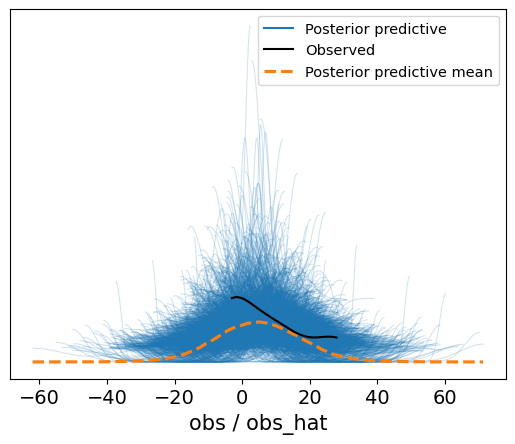

In [9]:
schools.posterior_predictive = schools.posterior_predictive.rename(obs="obs_hat")
# after this doing az.plot_ppc(schools) directly would raise an error
az.plot_ppc(schools, data_pairs={"obs": "obs_hat"});

The plot is the same, we have only renamed a variable, but the label is different now, and both the variable name in the observed data and in the posterior predictive groups are shown.

## `flatten`

`flatten` and `flatten_pp` are one of the main reasons for `plot_ppc`'s flexibility. We have seen so far how all observations within the same variable are flattened/marginalized together.
We can however, change that behaviour with the `flatten` and `flatten_pp` arguments. If we use an empty list, no dimension will be flattening, so in the basic case we will get one subplot per observation (so we plot only the first 5 to keep the plot smallish). We now need to use "scatter" kind because there is only one single observation per subplot:

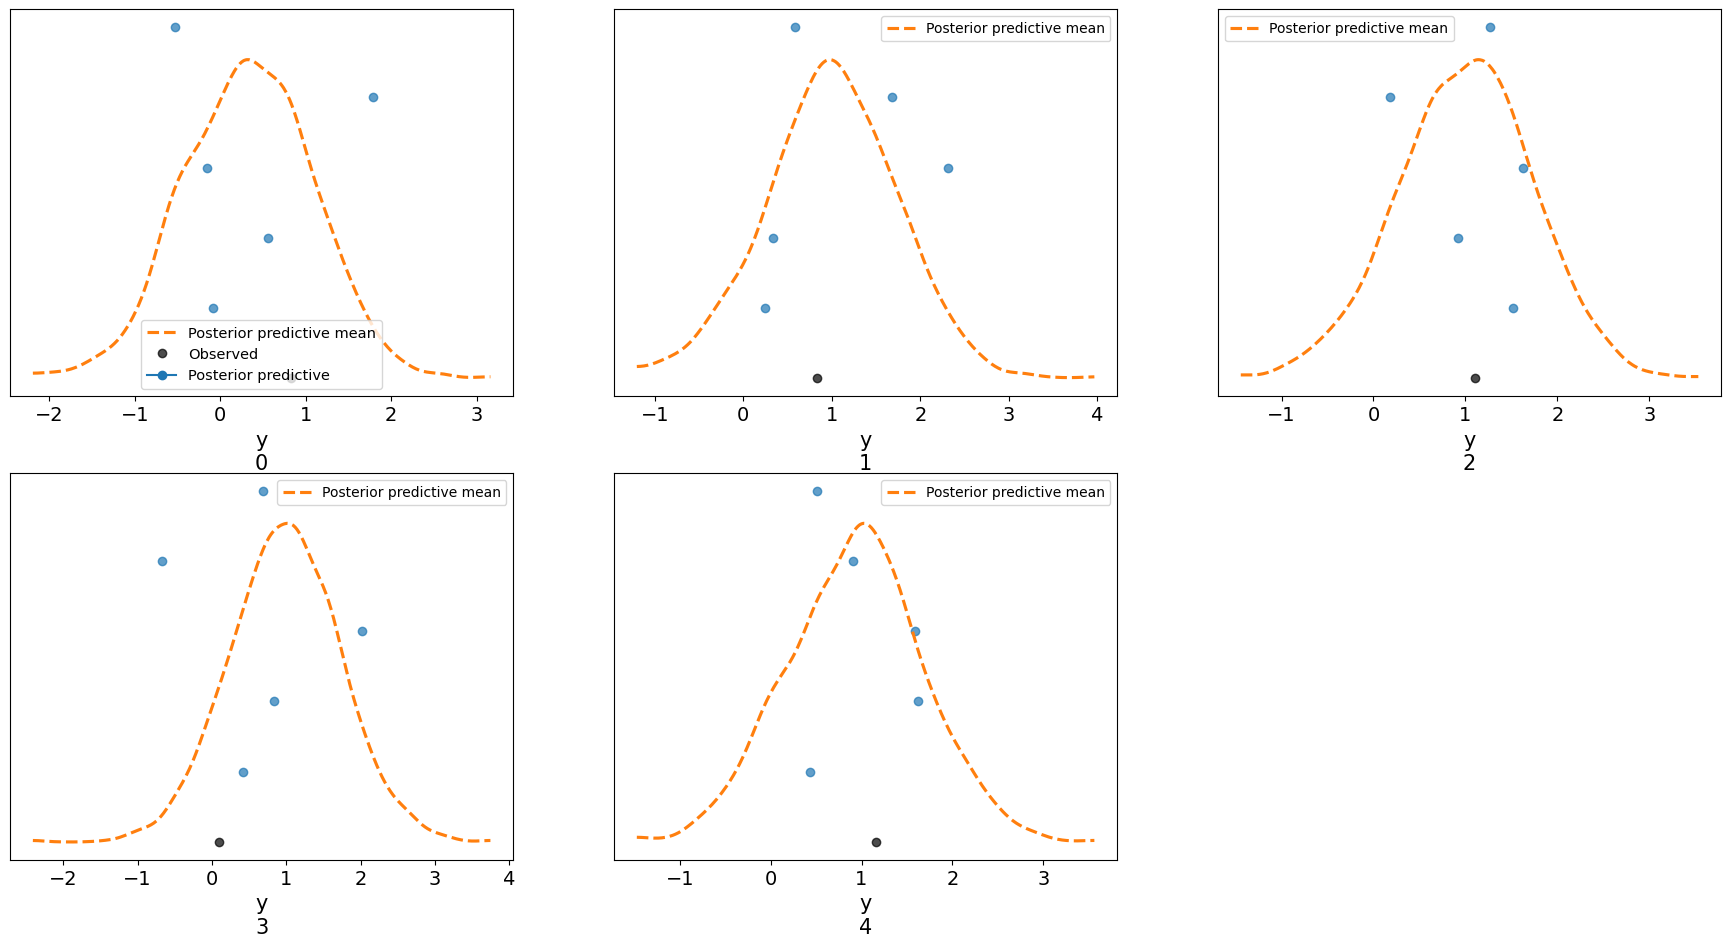

In [10]:
az.plot_ppc(radon, kind="scatter", coords={"obs_id": [0, 1, 2, 3, 4]}, flatten=[]);

This however is much more interesting if our coordinate values have repeated values! So far the `obs_id` dimension is indexed by a unique integer key, but each observation has associated one of 95 counties. So we can set the counties as coordinate values:

In [11]:
obs_county = radon.posterior["County"][radon.constant_data["county_idx"]]
radon = radon.assign_coords(obs_id=obs_county, groups="observed_vars")

radon

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Now, we can both use counties to define the subset that should be plotted and ArviZ will group observations of the same county into the same subplot. We'll also activate the observed rug to see how many observations there are in each group:

/home/oriolabrilpla/mambaforge/envs/arviz/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriolabrilpla/mambaforge/envs/arviz/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


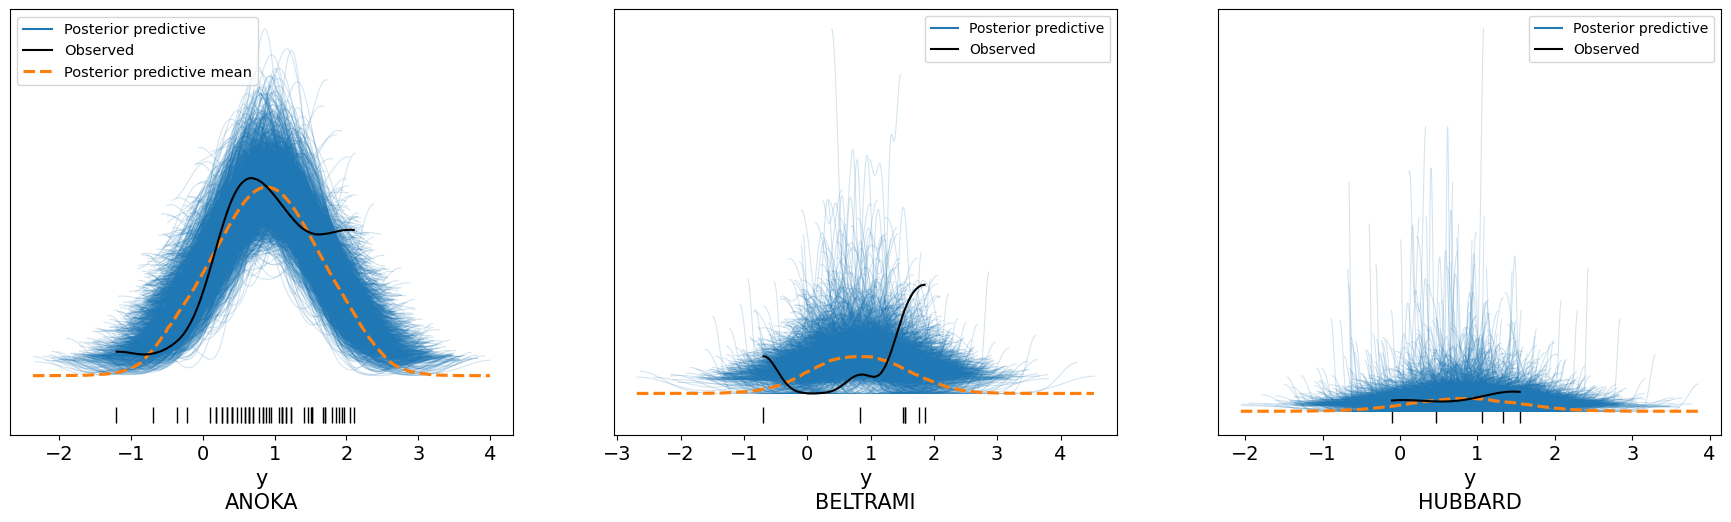

In [12]:
az.plot_ppc(radon, coords={"obs_id": ["ANOKA", "BELTRAMI", "HUBBARD"]}, flatten=[], observed_rug=True);

`flatten` is also critical for higher dimensional samples. The rugby model for example currently has 2 variables: `home_points` and `away_points` so the default is to flatten everything but generate one plot per variable. We could have however a single variable with dimensions `chain, draw, match, field`:

In [13]:
rugby.observed_data["points"] = xr.concat(
    (rugby.observed_data.home_points, rugby.observed_data.away_points),
    "field"
).assign_coords(field=["home", "away"])
rugby.posterior_predictive["points"] = xr.concat(
    (rugby.posterior_predictive.home_points, rugby.posterior_predictive.away_points),
    "field"
).assign_coords(field=["home", "away"])#.transpose("chain", "draw", ...)
rugby

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

If you expand the posterior predictive or observed data groups, you'll see there is a new variable called `points`. We can now plot the marginal over both match and field:

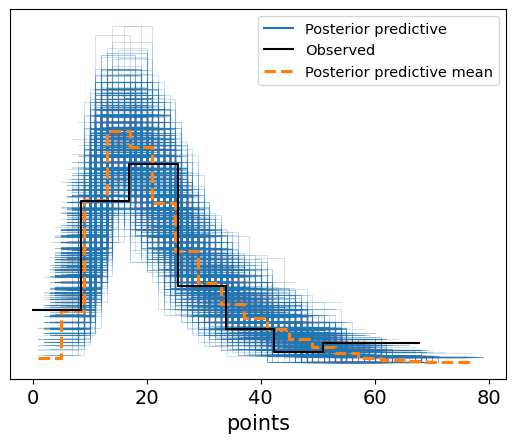

In [14]:
az.plot_ppc(rugby, var_names="points");

replicate the plot we generated above, where only the `match` dimension is flattened:

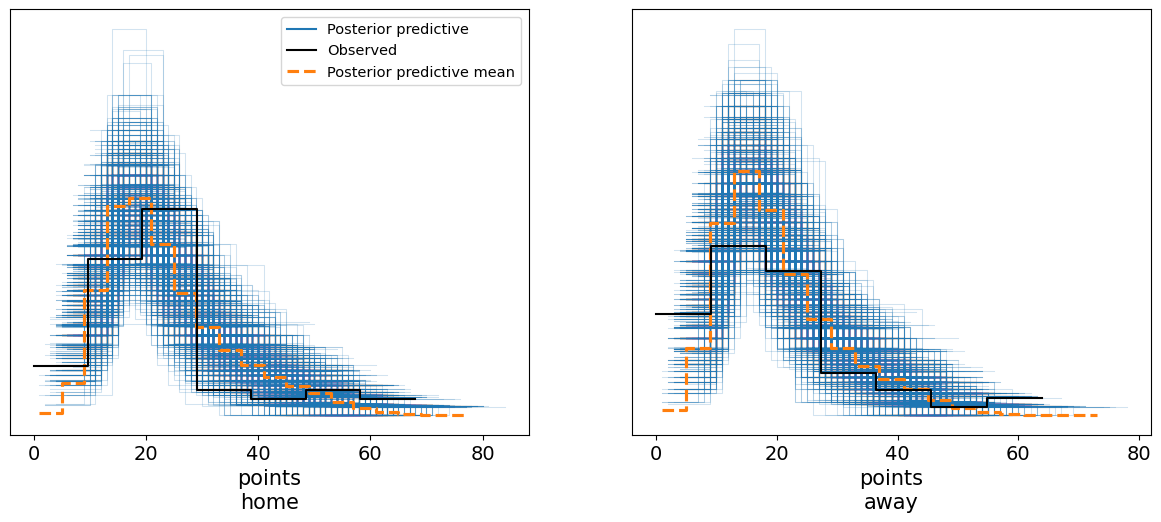

In [15]:
az.plot_ppc(rugby, var_names="points", flatten=["match"]);

or instead flatten the field dimension and check per match, how home and away goals compare to the predictions. Are there any matched that prove "problematic to predict"? We'll do that in the last section of the blog post.

## `num_pp_samples`

One possible complain from all the plots we have seen so far might be that there are way too many lines overlaid when kind is "kde" or "cumulative" and/or there are too few rug plots stacked vertically when kind is "scatter". We can control this with `num_pp_samples`:

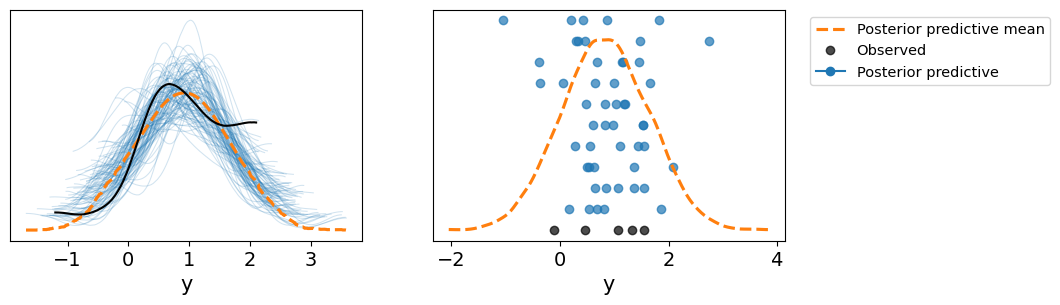

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
az.plot_ppc(radon, num_pp_samples=100, ax=axes[0], legend=False, coords={"obs_id": "ANOKA"})
az.plot_ppc(radon, num_pp_samples=10, ax=axes[1], kind="scatter", coords={"obs_id": "HUBBARD"})
axes[1].get_legend().set(bbox_to_anchor=(1.05, 1), loc='upper left');

Now though, we are plotting only a subset, which is chosen at random. To ensure reproducibililty, there is `random_seed`. Especially with the "scatter" kind it can also be interesting to have multiple `plot_ppc` calls use the same subset:

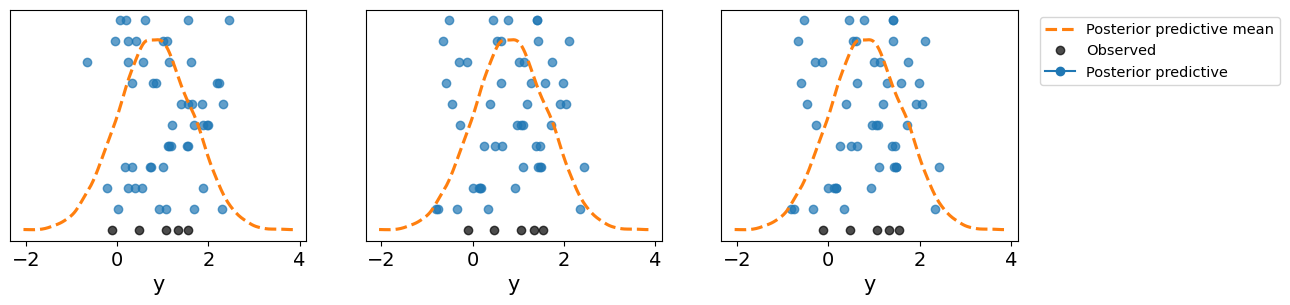

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(13, 3))
az.plot_ppc(radon, num_pp_samples=10, ax=axes[0], legend=False, kind="scatter", coords={"obs_id": "HUBBARD"})
az.plot_ppc(radon, num_pp_samples=10, random_seed=3, ax=axes[1], legend=False, kind="scatter", coords={"obs_id": "HUBBARD"})
az.plot_ppc(radon, num_pp_samples=10, random_seed=3, ax=axes[2], kind="scatter", coords={"obs_id": "HUBBARD"})
axes[2].get_legend().set(bbox_to_anchor=(1.05, 1), loc='upper left');

## `animated`

There is also the option of generating a video of the `plot_ppc`. Using 

    az.plot_ppc(radon, animated=True)
    
you will generate the following video:

![animation of a plot_ppc plot, where the mean and observed data lines are fixed and the animation shows one posterior predictive sample at each step.](ppc_anim.mp4)

Here is also a link to the [video file](ppc_anim.mp4) in case the embedded player doesn't work.

The `animated` feature hasn't received much attention, but I think it could be interesting to maintain and develop. Something that comes to mind is having it show only a handful of frames, stop for ~2 seconds on each frame and number each frame. Frames would be similar to current ones, but without mean nor observed data lines, only a single line which will generally be a posterior predictive one except in one of the frames where we'd use the observed data. The animation would then end showing the number of the frame containing the plot of the observed data.

If you guessed right then something is going on, either you have done so much {abbr}`EDA (Exploratory Data Analysis)` with your data that you have memorized how it looks, or more probably (I think?) there is some aspect of the observations that isn't captured by the model.

## Practical examples

We can now use all the arguments we have seen to dive deeper into the two main models we have used to illustrate their use.

### Radon model

:::{seealso}
:class: drowdown

The original model that generated the example inference data we are using is available at the [arviz_example_data repository](https://github.com/arviz-devs/arviz_example_data/blob/main/code/radon/radon.py). The model was taken from [PyMC example gallery](https://www.pymc.io/projects/examples/en/2022.12.0/case_studies/multilevel_modeling.html) which has more detailed explanation and references.
:::

And we can now also use that to explore in more detail the potentially problematic areas in the flattened `plot_ppc`, for example, observations below -2.

In [18]:
radon.observed_data.query({"obs_id": "y < -2"}).compute()

<xarray.Dataset>
Dimensions:  (obs_id: 3)
Coordinates:
  * obs_id   (obs_id) object 'CARVER' 'COTTONWOOD' 'MCLEOD'
    County   (obs_id) object 'CARVER' 'COTTONWOOD' 'MCLEOD'
Data variables:
    y        (obs_id) float64 -2.303 -2.303 -2.303
Attributes: (4)

We see there are only 3 observations lower than -2, and each corresponds to a different county. The two we have plotted so far looked good enough. What about these ones?

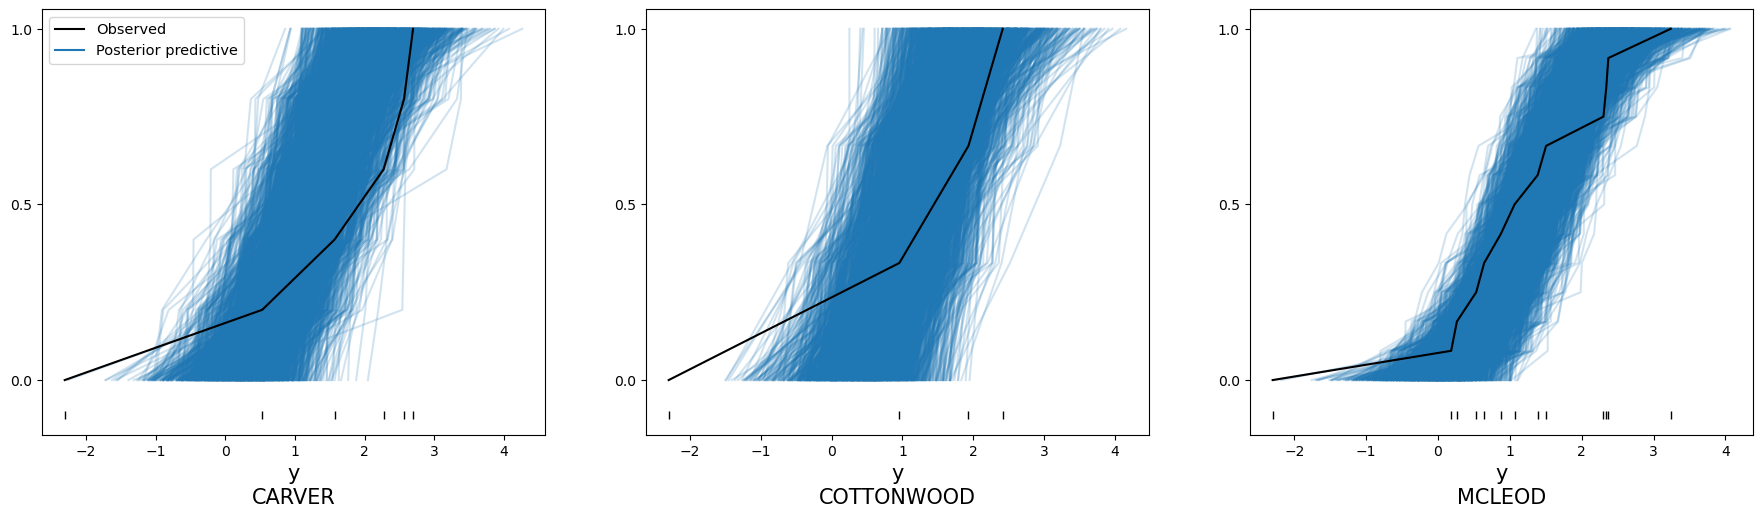

In [19]:
az.plot_ppc(radon, kind="cumulative", mean=False, coords={'obs_id': ['CARVER', 'COTTONWOOD', 'MCLEOD']}, flatten=[], observed_rug=True);

We can see that none of the groups predicts values as extreme as -2. In fact, after seeing that I went back to the model and data, and it turns out that that the radon data can't be lower than 0.1, and then the log is taken:

In [20]:
np.log(0.1)

-2.3025850929940455

However, this isn't taken into account in the model, which can assign non-zero probability to values lower than that for some groups:

In [21]:
lower_than_bound = (radon.posterior_predictive["y"].drop_vars("County") < np.log(0.1)).groupby("obs_id").sum().sum(("chain", "draw"))
lower_than_bound.isel(obs_id=lower_than_bound.argsort().values[-4:])

<xarray.DataArray 'y' (obs_id: 4)>
array([ 2,  3,  4, 10])
Coordinates:
  * obs_id   (obs_id) object 'ANOKA' 'BELTRAMI' 'KOOCHICHING' 'ST LOUIS'

This is quite negligible, but in my opinion still a good example of the things that can be found out with posterior predictive checks. I was also happy that after using the radon example countless times while teaching I still managed to discover a new fact about it.

### Rugby model

:::{seealso}
:class: drowdown

The original model that generated the example inference data we are using is available at the [arviz_example_data repository](https://github.com/arviz-devs/arviz_example_data/blob/main/code/rugby/rugby.ipynb). The model was taken from [PyMC example gallery](https://www.pymc.io/projects/examples/en/2022.12.0/case_studies/rugby_analytics.html) which has more detailed explanation and references.
:::

We have 60 matches in our dataset, coming from 4 different years. Teams play each other only once in the Six Nations championship, so we will have 4 matches where the same two teams play each other, but only 2 repetitions of unique match as the field factor is relevant to our model and it switches every year. We can combine the arrays of the home and away points to visualize "matches" instead of only points from one of the sides, also transform the match dimension into unique team pairings if we add a year dimension.

In [22]:
rugby = az.load_arviz_data("rugby")
rugby.map(
    lambda ds: ds.assign(points=xr.concat((ds.home_points, ds.away_points), "field")).assign_coords(field=["home", "away"]),
    groups="observed_vars",
    inplace=True
)

years = [2014, 2015, 2016, 2017]
all_matches = rugby.posterior_predictive.match.values.copy()
all_unique_matches = np.array([" ".join(sorted(match.split(" "))) for match in all_matches])
unique_match, unique_matches_id = np.unique(all_unique_matches, return_inverse=True)
indexes = np.argsort(unique_matches_id.reshape((4, 15)), axis=1)+15*np.arange(4)[:, None]
rugby.map(
    lambda ds: ds[["points"]].isel(match=xr.DataArray(indexes, dims=["year", "team_pair"])).assign_coords(year=years, team_pair=unique_match),
    groups="observed_vars",
    inplace=True
)
# keep track of which team played as home
home_team = np.array([m.split(" ")[0] for m in all_matches])[indexes]
rugby.observed_data["home_team"] = (("year", "team_pair"), home_team)
rugby.posterior_predictive

<xarray.Dataset>
Dimensions:    (field: 2, chain: 4, draw: 500, year: 4, team_pair: 15)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    match      (year, team_pair) object 'France England' ... 'Scotland Wales'
  * field      (field) <U4 'home' 'away'
  * year       (year) int64 2014 2015 2016 2017
  * team_pair  (team_pair) <U16 'England France' ... 'Scotland Wales'
Data variables:
    points     (field, chain, draw, year, team_pair) int64 9 19 14 ... 18 40 25
Attributes: (3)

It is probably better then to use "scatter" type of plot in this case. We will also restrict the output to a 4x2 grid:

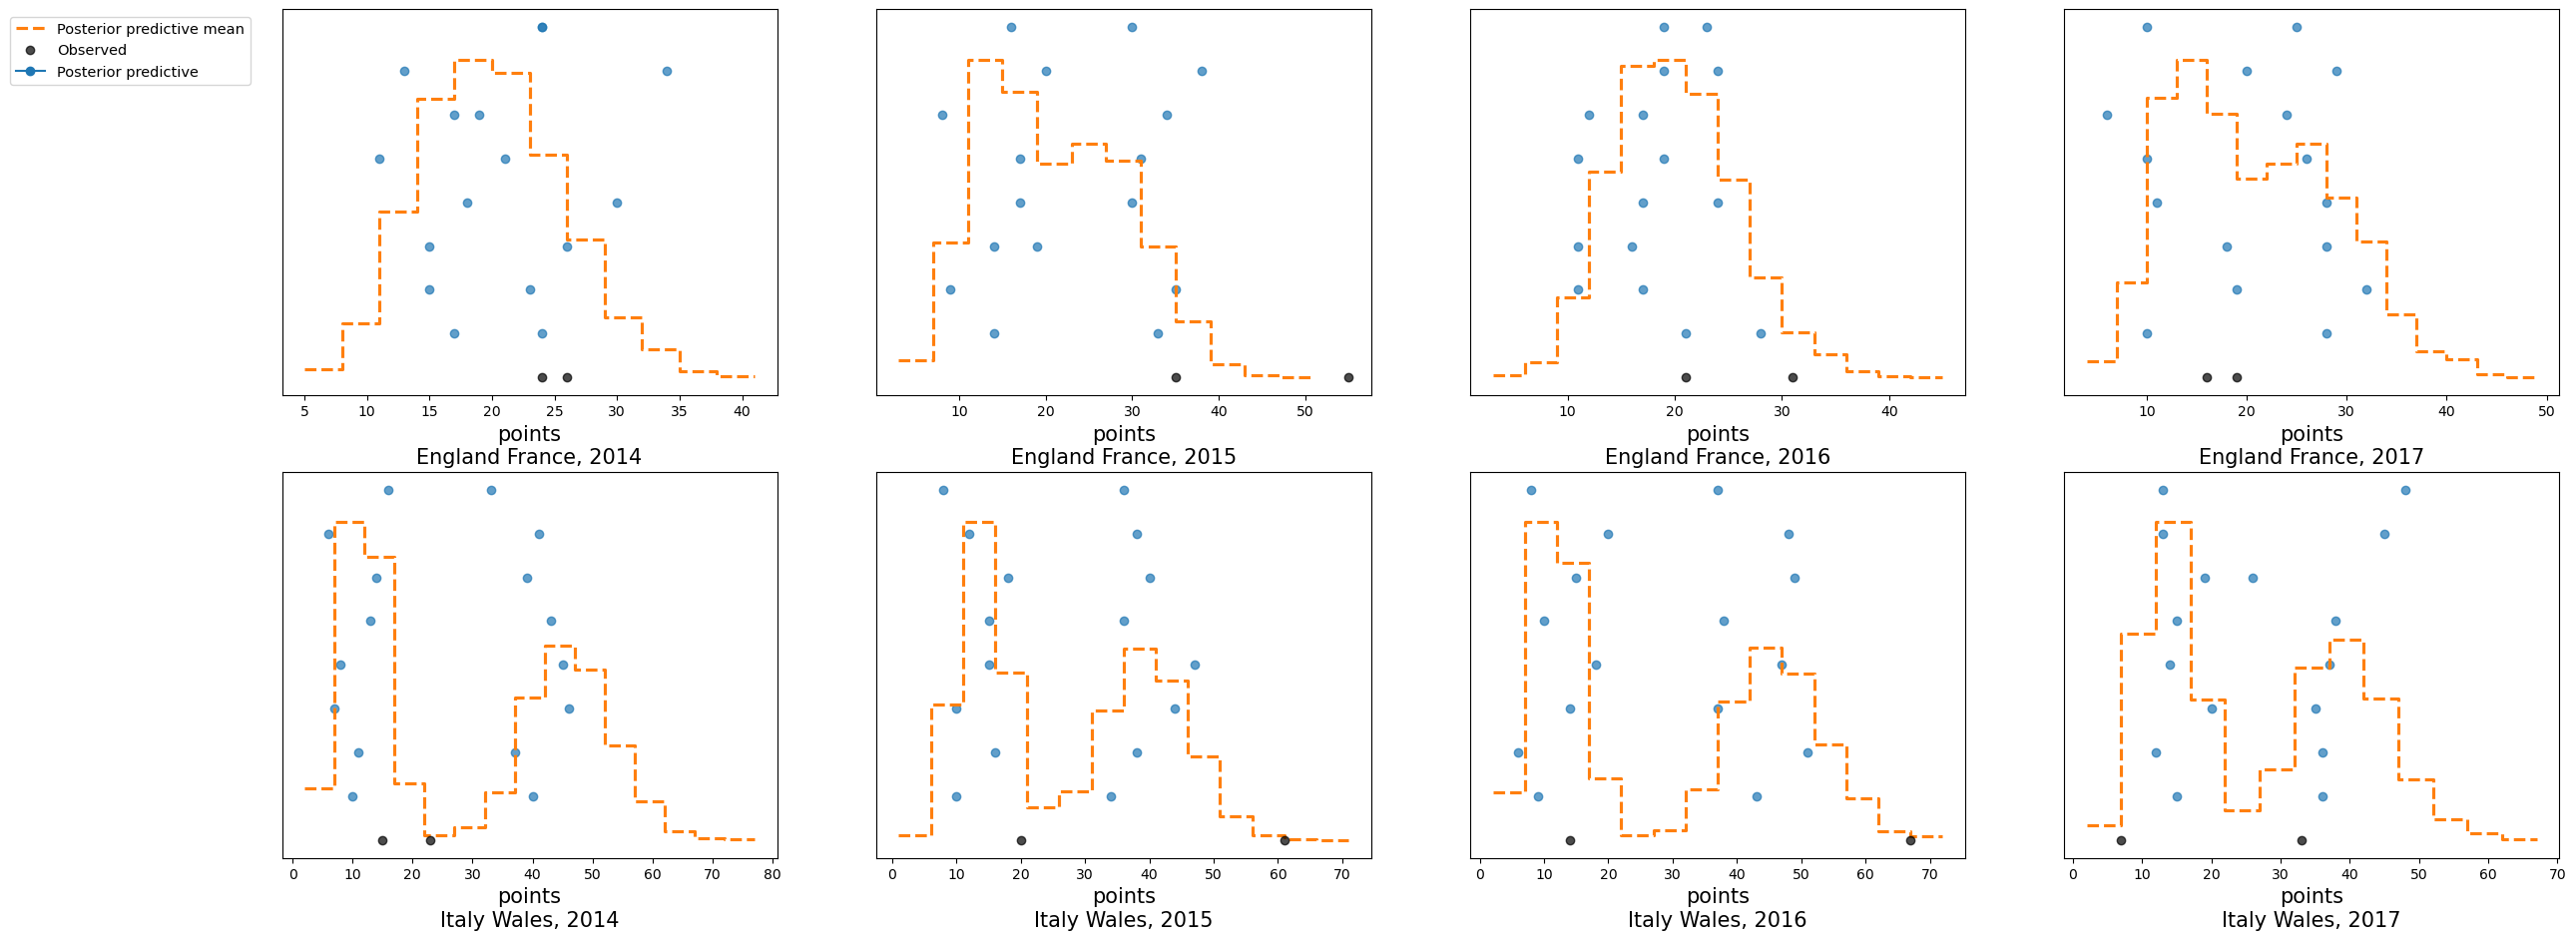

In [23]:
coords = {"team_pair": ["Italy Wales", "England France"]}
axes = az.plot_ppc(
    rugby.map(lambda ds: ds.transpose("team_pair", "year", ...), groups="observed_vars"),
    kind="scatter", var_names="points", flatten=["field"], coords=coords, random_seed=3, num_pp_samples=8
)
axes[0 ,0].get_legend().set(bbox_to_anchor=(-0.05, 1), loc='upper right');

This model only takes into account the defensive and ofensive strengths of each team and the home effect, there is no time component. That is, the first and third columns will show slightly different results due to the randomness of the posterior predictive sampling and the MCMC error, but they will be basically the same, as they are generated from the same parameterss. And the same happens with the second and fourth columns.

In fact, when we compare one column with the next we can see the effect of changing the home team between matches and how our model believes the outcome will change. For Italy vs Wales it doesn't do much, because Wales is much stronger than Italy, so it is only a matter of how large is the point difference, but for England vs France it has a significant effect on the win probabilities. Let's double check the home team first:

In 2014, when Wales and France were the home teams, their win probabilities according to this model are:

In [24]:
home_wins = rugby.posterior_predictive.points.sel(field="home") > rugby.posterior_predictive.points.sel(field="away")
home_wins.mean(("chain", "draw")).sel(year=2014, team_pair=["Italy Wales", "England France"]).to_series()

team_pair
Italy Wales       0.9995
England France    0.1450
Name: points, dtype: float64

On the other hand, in 2015 when Wale:s and France are the away teams, the model gives different probabilities, as we have seen specially 

In [25]:
(1-home_wins).mean(("chain", "draw")).sel(year=2015, team_pair=["Italy Wales", "England France"]).to_series()

team_pair
Italy Wales       0.9995
England France    0.0285
Name: points, dtype: float64

With the data structured like this, we can also generate a ppc plot similar to the one we did above using the `points` variable only, but without flattening the year dimension:

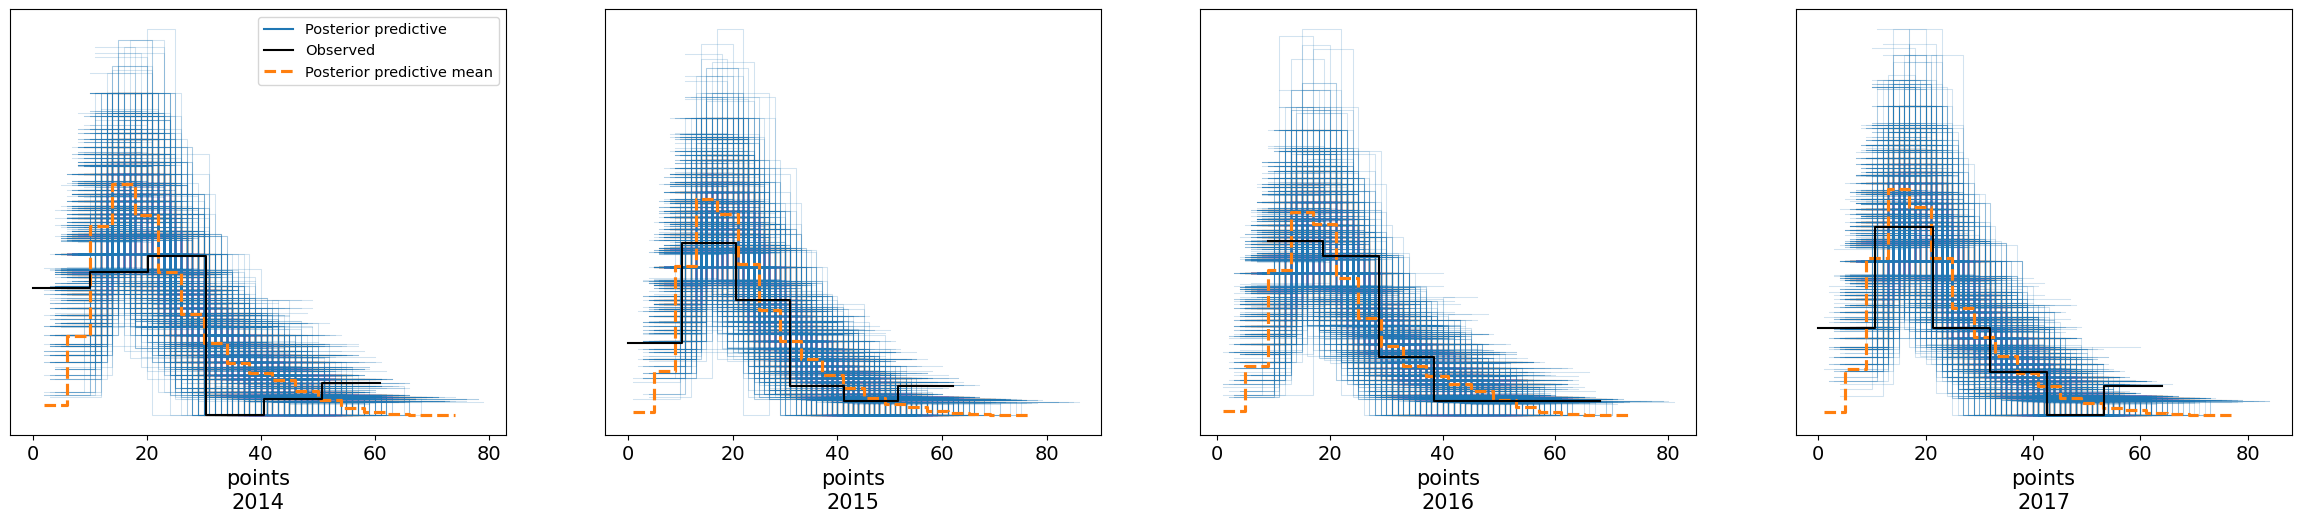

In [26]:
az.plot_ppc(rugby, var_names="points", flatten=["field", "team_pair"]);

These differences are probably related to how the home advantage changes between teams from year to year mostly, it is not as clear here as we saw with specific matches, but specially lower than ~30 points there seem to be alternating similarities 2014-2016 and 2015-2017. Intuitively, the next step being considered might be trying to incorporate the time dependency somehow, even with something as simple as "defending champion" effect, similar to the home field one. However, for this particular model, all ppc plots we have generated are quite sensible; the model is performing quite well already when it comes to predictions.

---

Package versions used to generate this post:

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Nov 17 2023

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.16.1

arviz     : 0.17.0.dev0
numpy     : 1.24.4
matplotlib: 3.8.0
xarray    : 2023.6.0

Watermark: 2.4.3



Comments are not enabled for this post, to inquiry further about the contents of the post, ask on [PyMC](https://discourse.pymc.io/) or [Stan](https://discourse.mc-stan.org/) Discourse forums, both have an `arviz` tag to ensure questions are sorted and interested people are notified.